# MODEL FRUIT METABOLISM (non FVA version)

### Import model

In [1]:
from cobra import io, flux_analysis, util
from cobra.core import Metabolite, Reaction
import numpy as np
from studyFunctions import *
%matplotlib inline

In [2]:
cobra_model2 = io.sbml.create_cobra_model_from_sbml_file("Models/ConstrainedFruitModel.xml")
if "cplex" in util.solvers.keys():
    cobra_model2.solver = "cplex"
else:
    cobra_model2.solver = "glpk"

List2edit = list()
for met in cobra_model2.metabolites:
    if met.id.endswith("_None"):
        List2edit.append(met)

for met in List2edit:
    met.id = met.id.replace("_None","")

cobra_model2.metabolites._generate_index()

# Validating the fruit model's metabolic content

In [3]:
from studyFunctions import generateBoundsFromBiomass


#Day time points of interest
DPA = list(np.linspace(8,59,11))

mets = ("GLC","FRU","SUC","MAL","CIT","L_ALPHA_ALANINE","ASN","L_ASPARTATE","GABA","GLT",
        "GLN","GLY","ILE","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL","Pi","FUM")
dfile="Data/Data_OrganicSolutes.csv"
Nsampl= 1000
Ssampl= 0.80

Conc = dict()
Conc_max = dict()
Conc_min = dict()
flux_max = dict()
flux_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [Conc[met],Conc_max[met],Conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,
                                                                                                met=met,
                                                                                                Nsampling=Nsampl,
                                                                                                DPA=DPA,
                                                                                                show_plots=False,
                                                                                                degree=3,
                                                                                                Ssampling=Ssampl,
                                                                                                start=8,stop=59)

mets = ("STARCH",)
dfile="Data/Data_Starch_Protein.csv"

for met in mets:
  print "Processing "+met+"..."
  [Conc[met],Conc_max[met],Conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,
                                                                                                met=met,
                                                                                                Nsampling=Nsampl,
                                                                                                DPA=DPA,
                                                                                                show_plots=False,
                                                                                                degree=3,
                                                                                                Ssampling=Ssampl,
                                                                                                start=8,stop=59)


Processing GLC...
Processing FRU...
Processing SUC...
Processing MAL...
Processing CIT...
Processing L_ALPHA_ALANINE...
Processing ASN...
Processing L_ASPARTATE...
Processing GABA...
Processing GLT...
Processing GLN...
Processing GLY...
Processing ILE...
Processing LYS...
Processing MET...
Processing PHE...
Processing PRO...
Processing SER...
Processing THR...
Processing TRP...
Processing TYR...
Processing VAL...
Processing Pi...
Processing FUM...
Processing STARCH...


In [4]:
Conc["SUCROSE"]=Conc["SUC"]
del Conc["SUC"]
del Conc["Pi"]

In [5]:
Conc["4_AMINO_BUTYRATE"]=Conc["GABA"]
del Conc["GABA"]

In [6]:
Conc_max["SUCROSE"]=Conc_max["SUC"]
del Conc_max["SUC"]
del Conc_max["Pi"]
Conc_max["4_AMINO_BUTYRATE"]=Conc_max["GABA"]
del Conc_max["GABA"]

In [7]:
Conc_min["SUCROSE"]=Conc_min["SUC"]
del Conc_min["SUC"]
del Conc_min["Pi"]
Conc_min["4_AMINO_BUTYRATE"]=Conc_min["GABA"]
del Conc_min["GABA"]

In [8]:
weightings = dict()
for rxn in cobra_model2.reactions:
    weightings[rxn.id]=1

for k in Conc.keys():
    for i in range(1,10):
        if k != "STARCH":
            met = Metabolite(k+str(i))
            rxn = cobra_model2.reactions.get_by_id(k+"_c_Transfer"+str(i)+str(i+1))
            rxn.add_metabolites({met:1})
            rxn = cobra_model2.reactions.get_by_id(k+"_v_Transfer"+str(i)+str(i+1))
            rxn.add_metabolites({met:1})
            rxn=Reaction(k+"_signal"+str(i))
            rxn.add_metabolites({met:-1})
            rxn.lower_bound = 0
            rxn.upper_bound = 1000
            cobra_model2.add_reaction(rxn)
            weightings[rxn.id]=0

solution2 = pfba_Weighted(cobra_model2,weightings)

    Processing results...

In [9]:

xlist = list()
for i in range(1,11):
    i=i*20
    xlist.append(i)
barwidth = 6
xlist2 = list()
for i in range(1,11):
    i=i*20
    xlist2.append(round(i-barwidth,2))

metdict = dict()
for met in Conc.keys():
    templist = list()
    for i in range(1,10):
        if met != "STARCH":
            templist.append(solution2.fluxes.get(met+"_c_Transfer"+str(i)+str(i+1))+solution2.fluxes.get(met+"_v_Transfer"+str(i)+str(i+1)))
        else:
            templist.append(solution2.fluxes.get(met+"_p_Transfer"+str(i)+str(i+1)))
    if met != "STARCH":
        templist.append(abs(solution2.fluxes.get("Final_Biomass_tx")*cobra_model2.reactions.get_by_id("Final_Biomass_tx").metabolites.get(cobra_model2.metabolites.get_by_id(met+"_b10"))))
    metdict[met]=templist



Text(0.04,0.5,'Metabolite content ($mmol.fruit^{-1}$)')

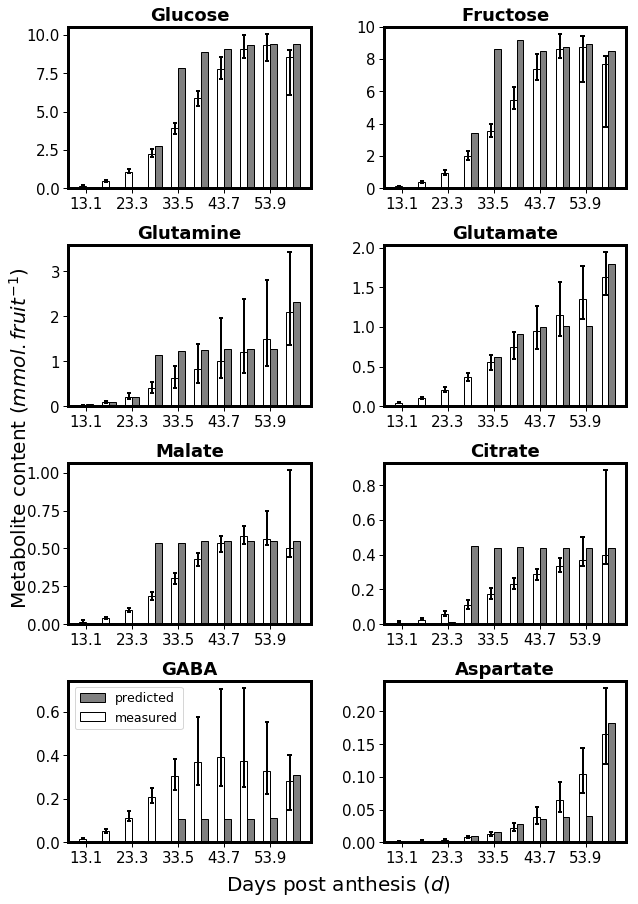

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(10,15))
titledict = {"GLC":"Glucose","FRU":"Fructose",
             "MAL":"Malate","CIT":"Citrate",
             "GLN":"Glutamine","GLT":"Glutamate",
             "4_AMINO_BUTYRATE":"GABA","L_ASPARTATE":"Aspartate"}
import string
alphabets = list(string.ascii_lowercase)

i=0
for met in ["GLC","FRU","GLN","GLT","MAL","CIT","4_AMINO_BUTYRATE","L_ASPARTATE"]:
    row = int(round(i/2))
    col = int(round(i%2))
    
    ax = axes[row,col]
    if met=="STARCH":
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",zorder=-1,label="predicted")
    else:
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",edgecolor="black",zorder=-1,label="predicted")
    
    offset2 = 0
    if col == 1:
        offset2 = 1
    ax.bar(xlist2,Conc[met][1:],width=barwidth,color="white",edgecolor="black",zorder=1,label="measured")
    for k in range(0,len(xlist2)):
        ax.plot([xlist2[k]+offset2,xlist2[k]+offset2],[Conc_max[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_max[met][1:][k],Conc_max[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_min[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
    ax.set_title(titledict[met],fontweight="bold")
    offset = float(barwidth)/2
    ax.set_xticks([round(xlist[0]-offset,2),round(xlist[2]-offset,2),round(xlist[4]-offset,2),round(xlist[6]-offset,2),round(xlist[8]-offset,2)])
    ax.set_xticklabels([round(DPA[1],1),round(DPA[3],1),round(DPA[5],1),round(DPA[7],1),round(DPA[9],1)])
    
    if met == "4_AMINO_BUTYRATE":
        ax.legend(loc="upper left",fontsize = 12.5)
    
    i=i+1
for j in range(i,8):
    row = int(round(j/2))
    col = int(round(j%2))
    ax = axes[row,col]
    ax.set_visible(False)
plt.subplots_adjust(wspace = 0.3,hspace=0.35)
fig.text(0.5, 0.08, 'Days post anthesis ($d$)', ha='center', fontsize=20)
fig.text(0.04, 0.5, 'Metabolite content ($mmol.fruit^{-1}$)', va='center', rotation='vertical', fontsize=20)


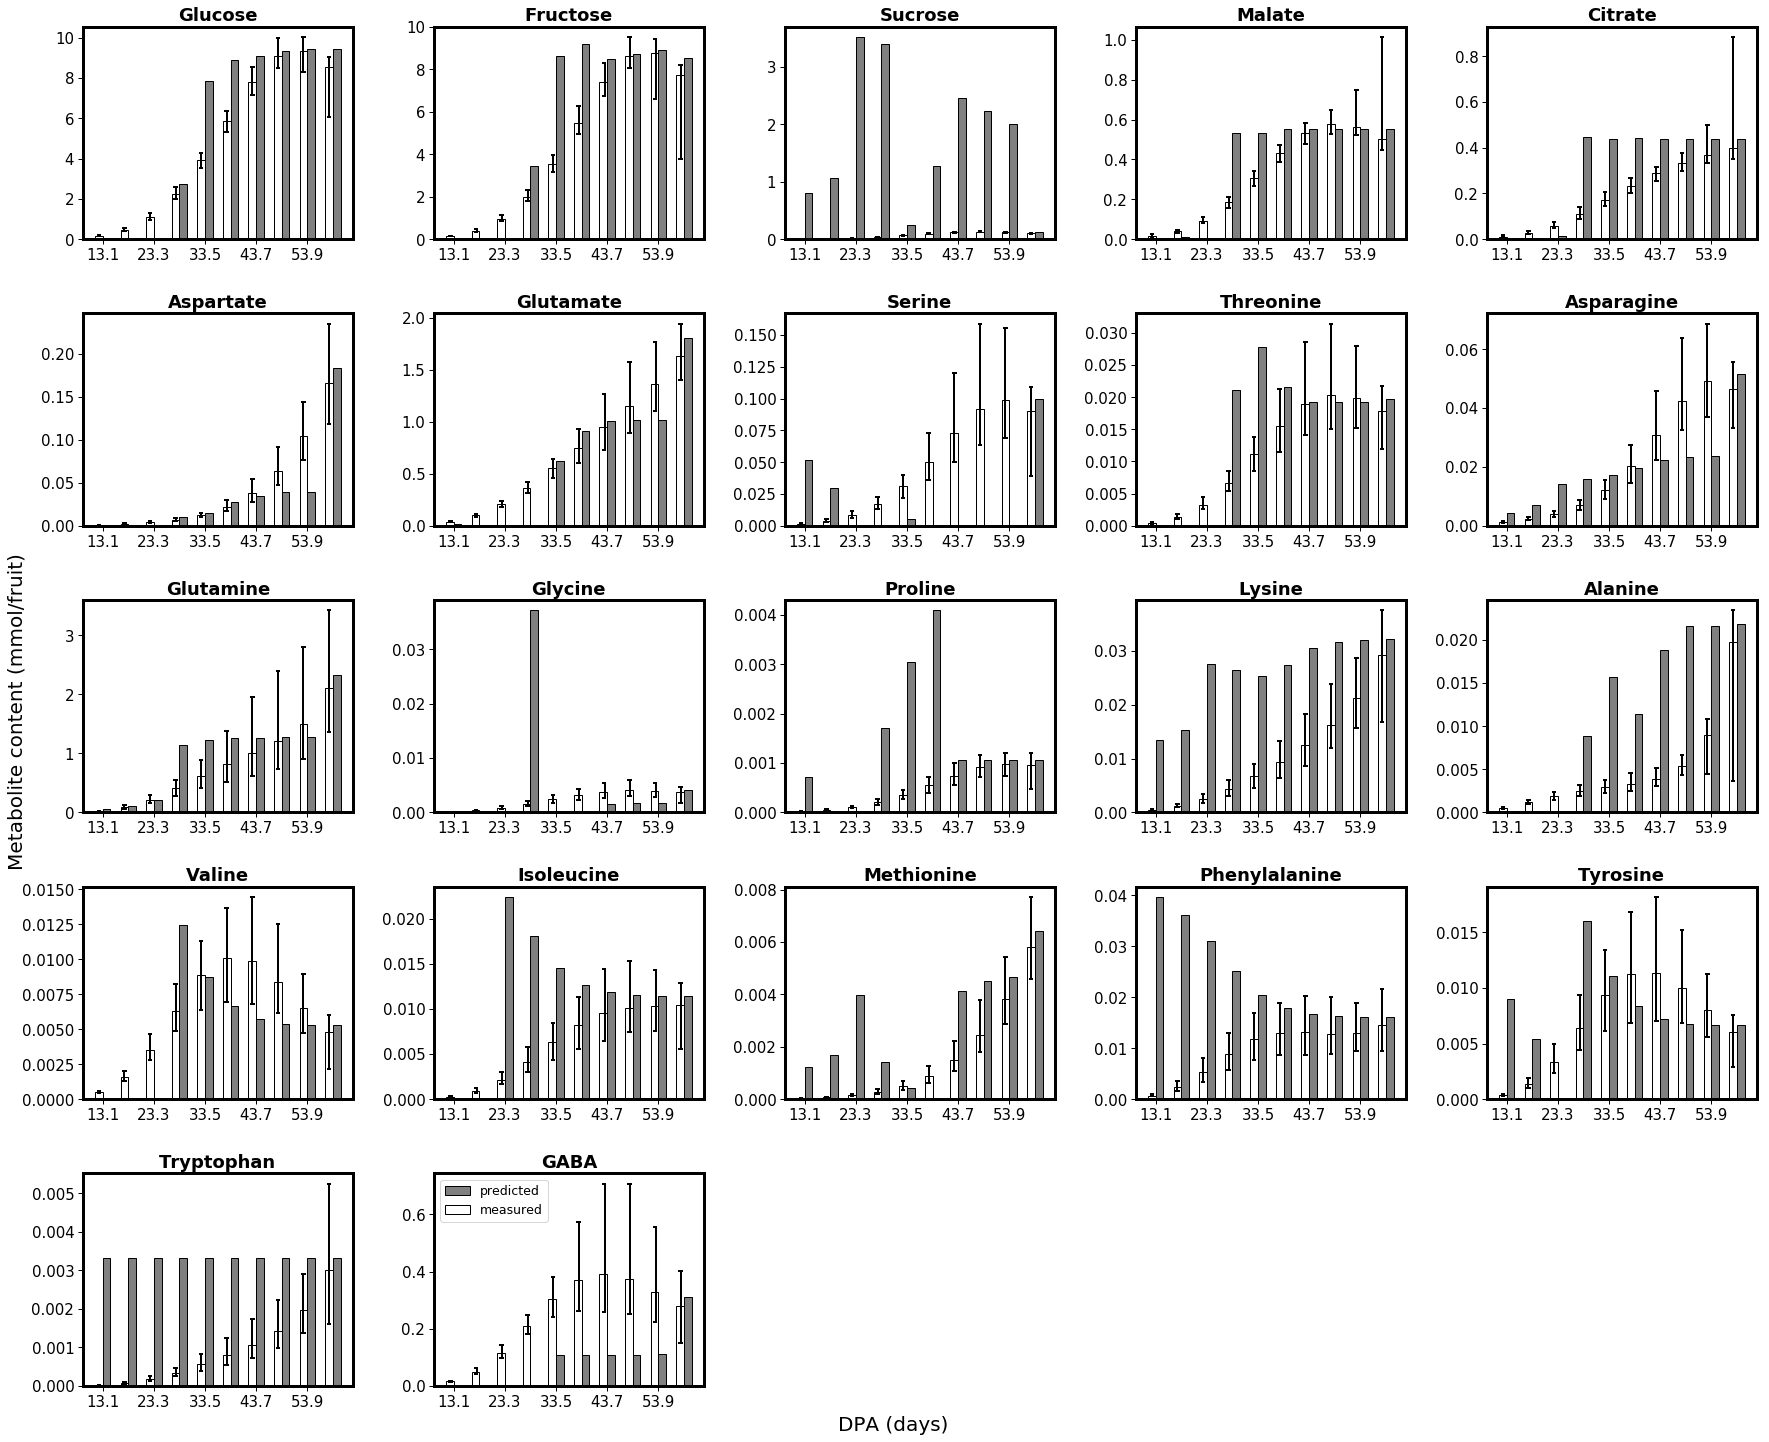

In [11]:
xlist3 = list()
for x in xlist:
    xlist3.append(x-7)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig, axes = plt.subplots(nrows=5,ncols=5,figsize=(30,25))
titledict = {"GLC":"Glucose","FRU":"Fructose","SUCROSE":"Sucrose","MAL":"Malate",
             "CIT":"Citrate","GLN":"Glutamine","GLT":"Glutamate","4_AMINO_BUTYRATE":"GABA",
             "L_ASPARTATE":"Aspartate","SER":"Serine","THR":"Threonine","ASN":"Asparagine",
             "GLY":"Glycine","PRO":"Proline","LYS":"Lysine","L_ALPHA_ALANINE":"Alanine",
             "VAL":"Valine","ILE":"Isoleucine","MET":"Methionine","PHE":"Phenylalanine",
             "TYR":"Tyrosine","TRP":"Tryptophan"}
import string
alphabets = list(string.ascii_lowercase)

i=0
for met in ["GLC","FRU","SUCROSE","MAL","CIT","L_ASPARTATE","GLT","SER","THR","ASN","GLN",
            "GLY","PRO","LYS","L_ALPHA_ALANINE","VAL","ILE","MET","PHE","TYR","TRP","4_AMINO_BUTYRATE"]:
    row = int(round(i/5))
    col = int(round(i%5))
    
    ax = axes[row,col]
    if met=="STARCH":
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",zorder=-1,label="predicted")
    else:
        ax.bar(xlist,metdict[met],width=barwidth,color="grey",edgecolor="black",zorder=-1,label="predicted")
    
    offset2 = 0
    if col == 1:
        offset2 = 1
    ax.bar(xlist2,Conc[met][1:],width=barwidth,color="white",edgecolor="black",zorder=1,label="measured")
    for k in range(0,len(xlist2)):
        ax.plot([xlist2[k]+offset2,xlist2[k]+offset2],[Conc_max[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_max[met][1:][k],Conc_max[met][1:][k]],color="black",linewidth=2)
        ax.plot([xlist2[k]+(float(offset2)/2)-1,xlist2[k]+(float(offset2)/2)+1],[Conc_min[met][1:][k],Conc_min[met][1:][k]],color="black",linewidth=2)
    ax.set_title(titledict[met],fontweight="bold")
    offset = float(barwidth)/2
    ax.set_xticks([round(xlist[0]-offset,2),round(xlist[2]-offset,2),round(xlist[4]-offset,2),round(xlist[6]-offset,2),round(xlist[8]-offset,2)])
    ax.set_xticklabels([round(DPA[1],1),round(DPA[3],1),round(DPA[5],1),round(DPA[7],1),round(DPA[9],1)])
    
    if met == "4_AMINO_BUTYRATE":
        ax.legend(loc="upper left",fontsize = 12.5)
    
    i=i+1
for j in range(i,25):
    row = int(round(j/5))
    col = int(round(j%5))
    ax = axes[row,col]
    ax.set_visible(False)
plt.subplots_adjust(wspace = 0.3,hspace=0.35)
fig.text(0.5, 0.1, 'DPA (days)', ha='center', fontsize=20)
fig.text(0.09, 0.5, 'Metabolite content (mmol/fruit)', va='center', rotation='vertical', fontsize=20)
plt.legend()
plt.show()

### Numbers of osmoles vs biomass

In [12]:
#Day time points of interest
DPA = list(np.linspace(8,59,11))
for i in range(0,len(DPA)):
    DPA[i]=round(DPA[i],1)

xlist = list()
ylist = list()
ylist2= list()
ylist3= list()
ylist4= list()
ylist5= list()
for i in range(1,10):
    xlist.append(i)
    ylist.append(celluloseLevels(DPA[i],Ncells = 25*(10**6)) * 180.16)
    ylist2.append(phospholipidLevels(DPA[i],Ncells = 25*(10**6),scaling_factor=100.0/8.512820512820287)*689.978637415773)
    ylist3.append(estimateProteinContent(DPA[i],ProtConc=21458.1747597,Ncell = 25*(10**6)) * 461.181100469)
    temp = 0
    temp2=0
    if i == 1:
        TEMP=0
        for rxn in cobra_model2.reactions.query("Initial"):
            for met in rxn.products:
                if not("CC" in met.id or "VC" in met.id or "CO" in met.id or "VO" in met.id or "PROTON" in met.id):
                    TEMP=TEMP+(met.formula_weight*solution2.fluxes.get(rxn.id))
    for rxn in cobra_model2.reactions.query("Transfer"+str(i)+str(i+1)):
        for met in rxn.reactants:
            if not("CC" in met.id or "VC" in met.id or "CO" in met.id or "VO" in met.id or "PROTON" in met.id):
                temp=temp+(met.formula_weight*solution2.fluxes.get(rxn.id))
                
    ylist4.append(temp)
    TEMP=temp
    if i == 1:
        TEMP2 = solution2.fluxes.get("Initial_STARCH_tx")*cobra_model2.metabolites.STARCH_p1.formula_weight
    temp2 = solution2.fluxes.get("STARCH_p_Transfer"+str(i)+str(i+1))*cobra_model2.metabolites.STARCH_p1.formula_weight
    ylist5.append(temp2)
    TEMP2 = temp2
    

ylist6=list()
for i in range(0,len(ylist5)):
    ylist6.append(ylist[i]+ylist2[i]+ylist3[i]+ylist4[i]+ylist5[i])


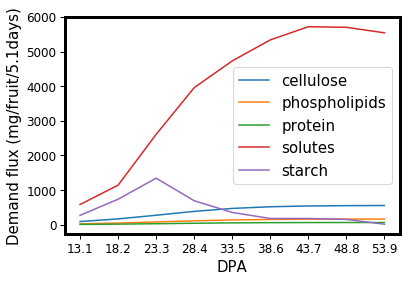

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

plt.xlabel("DPA")
plt.xticks(xlist,DPA[1:],fontsize=12)
plt.ylabel("Demand flux (mg/fruit/5.1days)")
plt.yticks(fontsize=12)
plt.plot(xlist,ylist,label="cellulose")
plt.plot(xlist,ylist2,label="phospholipids")
plt.plot(xlist,ylist3,label="protein")
plt.plot(xlist,ylist4,label="solutes")
plt.plot(xlist,ylist5,label="starch")
plt.legend(loc="best")

In [14]:
import pandas as pd
df3 = pd.DataFrame(data={"Phase":xlist,"cellulose":ylist,"phospholipids":ylist2,"protein":ylist3,"starch":ylist5,"solutes":ylist4,"total":ylist6})
df3

,Phase,cellulose,phospholipids,protein,solutes,starch,total
0,1,94.226241,27.939999,11.268824,585.881044,273.600069,992.916177
1,2,170.620394,50.634839,19.311164,1143.525478,738.311120,2122.402995
2,3,275.767896,81.881697,31.300670,2610.090999,1345.449744,4344.491006
3,4,387.488764,115.088436,45.143915,3957.163480,694.652719,5199.537314
4,5,472.679631,140.412413,56.103907,4728.607574,356.833471,5754.636996
5,6,520.922931,154.754066,62.174225,5336.167198,182.552937,6256.571358
6,7,543.440581,161.448221,64.789131,5715.370949,182.552937,6667.601819
7,8,552.962310,164.278916,65.748686,5699.335176,156.101111,6638.426199
8,9,556.816243,165.424648,66.057177,5539.750335,17.280061,6345.328463


In [15]:
y2list = list()
y2list2 = list()
y2list3 = list()
y2list4 = list()
y2list5 = list()
y2list6 = list()
for i in range(0,len(ylist)):
    y2list.append(round(100*ylist[i]/ylist6[i],2))
    y2list2.append(round(100*ylist2[i]/ylist6[i],2))
    y2list3.append(round(100*ylist3[i]/ylist6[i],2))
    y2list4.append(round(100*ylist4[i]/ylist6[i],2))
    y2list5.append(round(100*ylist5[i]/ylist6[i],2))

df4 = pd.DataFrame(data={"Phase":xlist,"cellulose":y2list,"phospholipids":y2list2,"protein":y2list3,"starch":y2list5,"solutes":y2list4,"total":ylist6})
df4

,Phase,cellulose,phospholipids,protein,solutes,starch,total
0,1,9.49,2.81,1.13,59.01,27.56,992.916177
1,2,8.04,2.39,0.91,53.88,34.79,2122.402995
2,3,6.35,1.88,0.72,60.08,30.97,4344.491006
3,4,7.45,2.21,0.87,76.11,13.36,5199.537314
4,5,8.21,2.44,0.97,82.17,6.20,5754.636996
5,6,8.33,2.47,0.99,85.29,2.92,6256.571358
6,7,8.15,2.42,0.97,85.72,2.74,6667.601819
7,8,8.33,2.47,0.99,85.85,2.35,6638.426199
8,9,8.78,2.61,1.04,87.30,0.27,6345.328463


#### Plot sucrose, starch in default, no phloem and no starch accumulation

In [16]:
     

cobra_model3 = cobra_model2.copy()

for i in range(1,11):
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000

temp_solution = pfba_Weighted(cobra_model3,weightings)       

    

cobra_model4 = cobra_model2.copy()

for i in range(1,10):
    cobra_model4.reactions.get_by_id("STARCH_p_Transfer"+str(i)+str(i+1)).lower_bound = 0
    cobra_model4.reactions.get_by_id("STARCH_p_Transfer"+str(i)+str(i+1)).upper_bound = 0

temp_solution2 = pfba_Weighted(cobra_model4,weightings)       


In [17]:

import numpy as np
#Day time points of interest
DAA = list(np.linspace(8,59,11))
for i in range(0,len(DAA)):
    DAA[i]=round(DAA[i],1)

mets = ("STARCH",)
dfile="Data/Data_Starch_Protein.csv"
Nsampl= 1000
Ssampl= 0.80

C_Jose = dict()
C_max_Jose = dict()
C_min_Jose = dict()
F_max = dict()
F_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [C_Jose[met],C_max_Jose[met],C_min_Jose[met],F_max[met],F_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=False,degree=3,Ssampling=Ssampl,start=8,stop=59)



Processing STARCH...


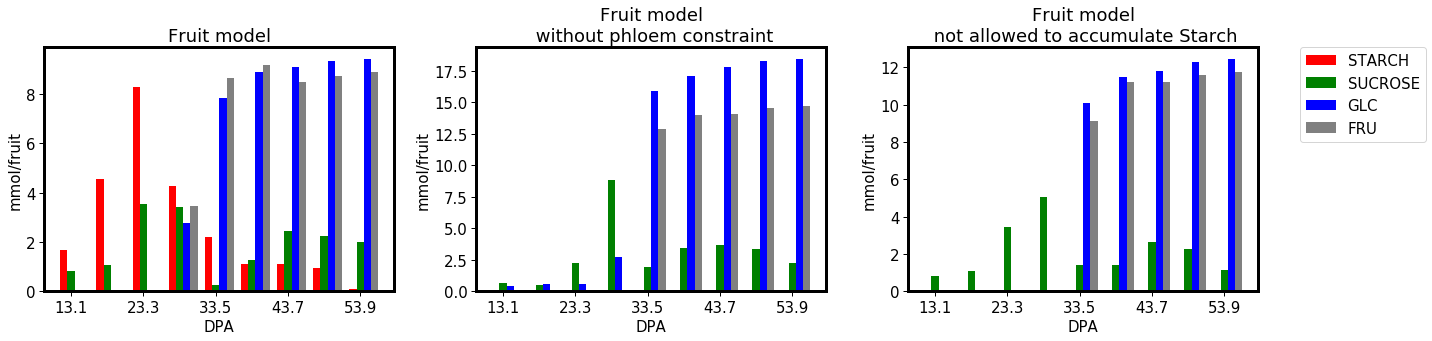

In [18]:


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,5))


ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
templist = list()
templistB = list()
templist2 = list()
templist2B = list()
templist3 = list()
templist3B = list()
templistC = list()
templistD = list()
templist2C = list()
templist2D = list()
templist3C = list()
templist3D = list()
xlist = list()
xlist2 = list()
xlist3 = list()
xlist4 = list()
xlist5 = list()
for i in range(1,10):
    xlist.append(i*10)
    xlist2.append(i*10+2)
    xlist3.append(i*10+4)
    xlist4.append(i*10+6)
    templist.append(solution2.fluxes["STARCH_p_Transfer"+str(i)+str(i+1)])
    templistB.append(solution2.fluxes["SUCROSE_v_Transfer"+str(i)+str(i+1)]+solution2.fluxes["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templistC.append(solution2.fluxes["GLC_v_Transfer"+str(i)+str(i+1)]+solution2.fluxes["GLC_c_Transfer"+str(i)+str(i+1)])
    templistD.append(solution2.fluxes["FRU_v_Transfer"+str(i)+str(i+1)]+solution2.fluxes["FRU_c_Transfer"+str(i)+str(i+1)])
    templist2.append(temp_solution.fluxes["STARCH_p_Transfer"+str(i)+str(i+1)])
    templist2B.append(temp_solution.fluxes["SUCROSE_v_Transfer"+str(i)+str(i+1)]+temp_solution.fluxes["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templist2C.append(temp_solution.fluxes["GLC_v_Transfer"+str(i)+str(i+1)]+temp_solution.fluxes["GLC_v_Transfer"+str(i)+str(i+1)])
    templist2D.append(temp_solution.fluxes["FRU_v_Transfer"+str(i)+str(i+1)]+temp_solution.fluxes["FRU_v_Transfer"+str(i)+str(i+1)])
    templist3.append(temp_solution2.fluxes["STARCH_p_Transfer"+str(i)+str(i+1)])
    templist3B.append(temp_solution2.fluxes["SUCROSE_v_Transfer"+str(i)+str(i+1)]+temp_solution2.fluxes["SUCROSE_c_Transfer"+str(i)+str(i+1)])
    templist3C.append(temp_solution2.fluxes["GLC_v_Transfer"+str(i)+str(i+1)]+temp_solution2.fluxes["GLC_v_Transfer"+str(i)+str(i+1)])
    templist3D.append(temp_solution2.fluxes["FRU_v_Transfer"+str(i)+str(i+1)]+temp_solution2.fluxes["FRU_v_Transfer"+str(i)+str(i+1)])

    ax1.bar(xlist,templist,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist2,templistB,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist3,templistC,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax1.bar(xlist4,templistD,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist,templist2,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist2,templist2B,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax2.bar(xlist3,templist2C,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax2.bar(xlist4,templist2D,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist,templist3,width=2,color="red",zorder=-1,label="STARCH")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist2,templist3B,width=2,color="green",zorder=-1,label="SUCROSE")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist2:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)


ax3.bar(xlist3,templist3C,width=2,color="blue",zorder=-1,label="GLC")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist3:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax3.bar(xlist4,templist3D,width=2,color="grey",zorder=-1,label="FRU")
tempxlist1 = list()
tempxlist2 = list()
for x in xlist4:
    tempxlist1.append(x+0.5)
    tempxlist2.append(x-0.5)

ax1.set_title("Fruit model")

ax2.set_title("Fruit model\n without phloem constraint")

ax3.set_title("Fruit model\n not allowed to accumulate Starch")



plt.legend(bbox_to_anchor=(1.5, 1.03),fontsize=15)
for i in range(0,3):
    axes[i].set_xticks([xlist2[0],xlist2[2],xlist2[4],xlist2[6],xlist2[8]])
    axes[i].set_xticklabels([DPA[1],DPA[3],DPA[5],DPA[7],DPA[9]])
    axes[i].set_xlabel("DPA")
    axes[i].set_ylabel("mmol/fruit")
plt.tight_layout()
plt.show()

### Compare Phloem uptake rate

In [19]:


rxnlist= list()
for i in range(1,11):
    for met in ["Phloem_uptake_tx","CO2_tx"]:
        rxnlist.append(cobra_model2.reactions.get_by_id(met+str(i)))

cobra_model3 = cobra_model2.copy()

for i in range(1,11):
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    cobra_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000

temp_solution = pfba_Weighted(cobra_model3,weightings)        



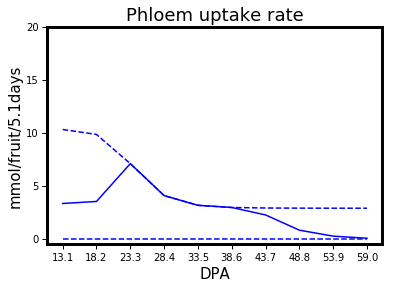

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

templist = list()
templist2 = list()
templist3 = list()
xlist = list()
upper_limit = list()
for i in range(1,11):
    xlist.append(i)
    upper_limit.append(cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound)
    templist.append(solution2.fluxes["Phloem_uptake_tx"+str(i)])
    templist2.append(temp_solution.fluxes["Phloem_uptake_tx"+str(i)])
plt.plot(xlist,templist,"-",color="blue",label="phloem uptake when constrained")
plt.plot(xlist,upper_limit,"--",color="blue")
plt.plot(xlist,[0]*len(xlist),"--",color="blue",label="phloem uptake constraint")

plt.title("Phloem uptake rate")
plt.ylim(-0.5,20)
plt.yticks(fontsize=10)
plt.xticks(xlist,DPA[1:],fontsize=10)
plt.xlabel("DPA")
plt.ylabel("mmol/fruit/5.1days")
plt.show()


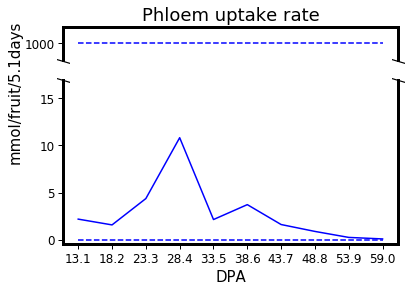

In [21]:
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

fig=plt.subplots(sharex=True)
gs = gridspec.GridSpec(2,1,height_ratios=[1,5])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

templist = list()
templist2 = list()
templist3 = list()
xlist = list()
upper_limit = list()
for i in range(1,11):
    xlist.append(i)
    upper_limit.append(cobra_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound)
    templist.append(solution2.fluxes["Phloem_uptake_tx"+str(i)])
    templist2.append(temp_solution.fluxes["Phloem_uptake_tx"+str(i)])
    
ax1.plot(xlist,templist2,"-",label="Phloem uptake when unconstrained",color="blue")
ax0.plot(xlist,[1000]*len(xlist),"--",color="blue")
ax1.plot(xlist,[0]*len(xlist),"--",color="blue",label="phloem uptake constraint")


ax0.spines["bottom"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax0.tick_params(bottom=False,labelbottom=False)
ax1.tick_params(top=False)
ax0.set_ylim(990,1010)
ax0.set_yticks([1000])
ax1.set_ylim(-0.5,17)


ax0.set_title("Phloem uptake rate")
#plt.ylim(-0.5,4.5)
#plt.yticks(fontsize=10)
plt.xticks(xlist,DPA[1:],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("DPA")
plt.text(-1.1,22,"mmol/fruit/5.1days",rotation=90)
plt.text(0.4,16,"/",rotation=90)
plt.text(10.3,16,"/",rotation=90)
plt.text(0.4,18,"/",rotation=90)
plt.text(10.3,18,"/",rotation=90)
ax0.tick_params(axis='both', which='major', labelsize=12)
plt.show()


### Write flux distribution to file

In [22]:
writeSolutionFluxesToFile(solution2,"FruitFluxes.csv",cobra_model2)

---

### Osmoles

In [23]:
cobra_model2.metabolites.query("WCO")

[<Metabolite WCO_1 at 0x7f647ec23a90>,
 <Metabolite WCO_2 at 0x7f647ec23b10>,
 <Metabolite WCO_3 at 0x7f647ec23b50>,
 <Metabolite WCO_4 at 0x7f647ec23b90>,
 <Metabolite WCO_5 at 0x7f647ec23bd0>,
 <Metabolite WCO_6 at 0x7f647ec23c10>,
 <Metabolite WCO_7 at 0x7f647ec23c50>,
 <Metabolite WCO_8 at 0x7f647ec23c90>,
 <Metabolite WCO_9 at 0x7f647ec23cd0>,
 <Metabolite WCO_10 at 0x7f647ec23d10>]

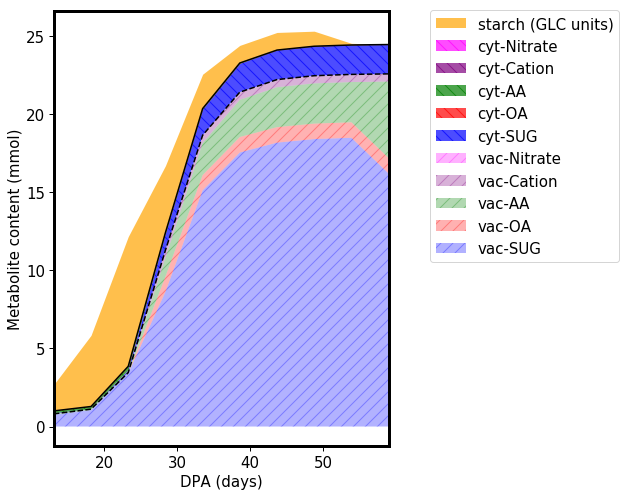

In [24]:
SOL = solution2

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.fluxes.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.fluxes.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.fluxes.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.fluxes.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.fluxes.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.fluxes.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.fluxes.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.fluxes.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.fluxes.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.fluxes.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.fluxes.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.fluxes.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.fluxes.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.fluxes.get(rxn.id)
        else:
            y12 = y12 + SOL.fluxes.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.fluxes.get(rxn.id)
        else:
            y13 = y13 + SOL.fluxes.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.fluxes.get(rxn.id)
        else:
            y14 = y14 + SOL.fluxes.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC units)",linewidth=0)

handles, labels = plt.gca().get_legend_handles_labels()
labels.reverse()
handles.reverse()
lgd=plt.legend(handles,labels,bbox_to_anchor=(1.1, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Phytol and Lycopene constraints added

In [25]:
temp_model = cobra_model2.copy()
unit_time = 5.1

#Day time points of interest
DPA = list(np.linspace(8,59,11))
for i in range(0,len(DPA)):
    DPA[i]=round(DPA[i],1)

for i in range(1,11):
    rxn = temp_model.reactions.get_by_id("Lycopene_biomass_demand_tx"+str(i))
    rxn.lower_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)       #mmol/fruit/5.1day
    rxn.upper_bound = float(estimateLycopeneDemand(DPA[i],unit_time)*0.001)       #mmol/fruit/5.1day
    rxn = temp_model.reactions.get_by_id("Phytol_biomass_demand_tx"+str(i))
    rxn.lower_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day
    rxn.upper_bound = float(estimatePhytolDemand(DPA[i],unit_time)*0.001)         #mmol/fruit/5.1day

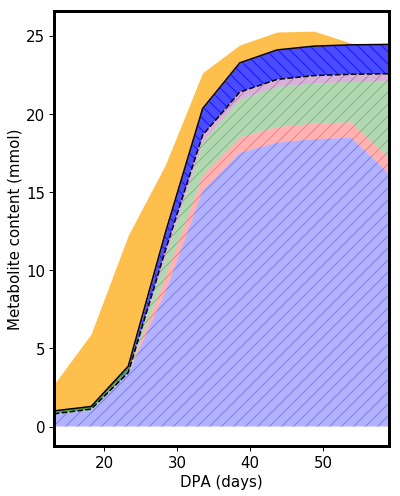

In [26]:
SOLtemp = pfba_Weighted(temp_model,weightings)
SOL = SOLtemp

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.fluxes.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.fluxes.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.fluxes.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.fluxes.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.fluxes.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.fluxes.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.fluxes.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.fluxes.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.fluxes.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.fluxes.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.fluxes.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.fluxes.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.fluxes.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.fluxes.get(rxn.id)
        else:
            y12 = y12 + SOL.fluxes.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.fluxes.get(rxn.id)
        else:
            y13 = y13 + SOL.fluxes.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.fluxes.get(rxn.id)
        else:
            y14 = y14 + SOL.fluxes.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Phloem uptake constraint removed

In [27]:
temp_model2 = temp_model.copy()
for i in range(1,11):
    temp_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000
    temp_model2.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0

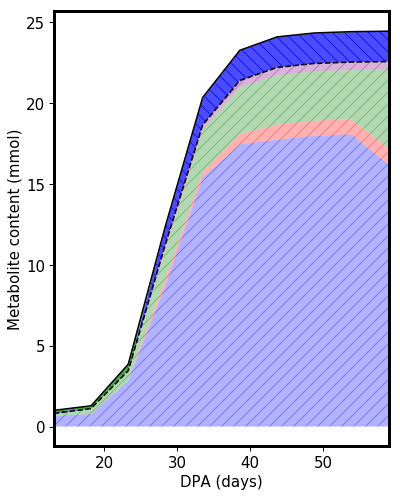

In [28]:
SOL = pfba_Weighted(temp_model2,weightings)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.fluxes.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.fluxes.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.fluxes.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.fluxes.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.fluxes.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.fluxes.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.fluxes.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.fluxes.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.fluxes.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.fluxes.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.fluxes.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.fluxes.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.fluxes.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.fluxes.get(rxn.id)
        else:
            y12 = y12 + SOL.fluxes.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.fluxes.get(rxn.id)
        else:
            y13 = y13 + SOL.fluxes.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.fluxes.get(rxn.id)
        else:
            y14 = y14 + SOL.fluxes.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Phloem uptake and osmolarity constraint removed

In [29]:
temp_model3 = temp_model2.copy()
for i in range(1,11):
    temp_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).upper_bound = 1000
    temp_model3.reactions.get_by_id("Phloem_uptake_tx"+str(i)).lower_bound = 0
    temp_model3.metabolites.get_by_id("VO_"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CO_"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CC_v"+str(i)).remove_from_model()
    temp_model3.metabolites.get_by_id("CC_c"+str(i)).remove_from_model()

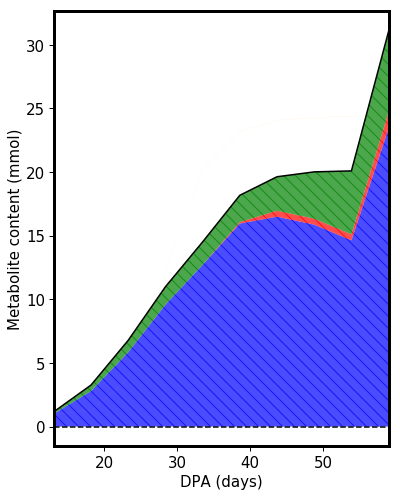

In [30]:
SOL = pfba_Weighted(temp_model3,weightings)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.fluxes.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.fluxes.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.fluxes.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.fluxes.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.fluxes.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.fluxes.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.fluxes.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.fluxes.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.fluxes.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.fluxes.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.fluxes.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.fluxes.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.fluxes.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.fluxes.get(rxn.id)
        else:
            y12 = y12 + SOL.fluxes.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.fluxes.get(rxn.id)
        else:
            y13 = y13 + SOL.fluxes.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.fluxes.get(rxn.id)
        else:
            y14 = y14 + SOL.fluxes.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Removing biomass constraints

In [31]:
temp_model4 = temp_model3.copy()
for i in range(1,11):
    rxn = temp_model3.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model3.reactions.get_by_id("phospholipid_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model3.reactions.get_by_id("CELLULOSE_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0

tempList = list()
for met in temp_model4.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if "PROTON" in met.id or "SUCROSE" in met.id or "GLC" in met.id or "FRU" in met.id:
        continue
    tempList.append(met.id[0:len(met.id)-1])
    
for Met in tempList[0:4]+tempList[5:6]+tempList[8:9]+tempList[10:13]:
    for i in range(1,11):
        met = temp_model4.metabolites.get_by_id(Met+str(i))
        rxn = temp_model4.reactions.get_by_id("Phloem_uptake_tx"+str(i))
        coeff = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-1*coeff})

SOL = pfba_Weighted(temp_model4,weightings)

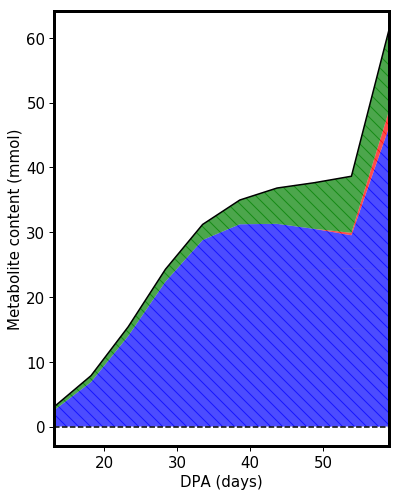

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.fluxes.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.fluxes.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.fluxes.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.fluxes.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.fluxes.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.fluxes.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.fluxes.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.fluxes.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.fluxes.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.fluxes.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.fluxes.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.fluxes.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.fluxes.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.fluxes.get(rxn.id)
        else:
            y12 = y12 + SOL.fluxes.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.fluxes.get(rxn.id)
        else:
            y13 = y13 + SOL.fluxes.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.fluxes.get(rxn.id)
        else:
            y14 = y14 + SOL.fluxes.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()

### Removing biomass constraints in system with osmotic constraints

In [33]:
temp_model5 = temp_model2.copy()
for i in range(1,11):
    rxn = temp_model2.reactions.get_by_id("Protein_biomass_demand_tx"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model2.reactions.get_by_id("phospholipid_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0
    rxn = temp_model2.reactions.get_by_id("CELLULOSE_accumulation"+str(i))
    rxn.lower_bound = 0
    rxn.upper_bound = 0

tempList = list()
for met in temp_model5.reactions.get_by_id("Phloem_uptake_tx1").metabolites.keys():
    if "PROTON" in met.id or "SUCROSE" in met.id or "GLC" in met.id or "FRU" in met.id:
        continue
    tempList.append(met.id[0:len(met.id)-1])
    
for Met in tempList[0:4]+tempList[5:6]+tempList[8:9]+tempList[10:13]:
    for i in range(1,11):
        met = temp_model5.metabolites.get_by_id(Met+str(i))
        rxn = temp_model5.reactions.get_by_id("Phloem_uptake_tx"+str(i))
        coeff = rxn.metabolites.get(met)
        rxn.add_metabolites({met:-1*coeff})

SOL = pfba_Weighted(temp_model5,weightings)

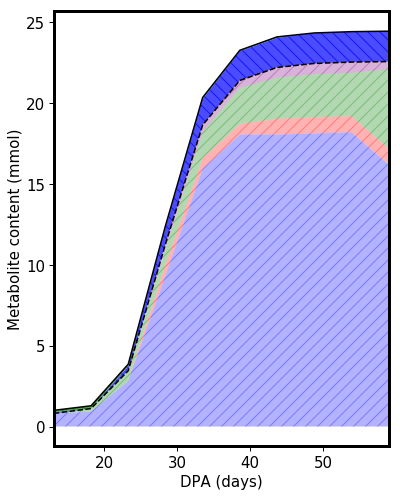

In [34]:
SOL = pfba_Weighted(temp_model5,weightings)

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker
plt.figure(figsize=(6,8))

ax1 = plt.subplot(1,1,1)

xlist = list()
ylist = list()
y2list = list()
y3list = list()
y4list = list()
y5list = list()
y6list = list()
y7list = list()
y8list = list()
y9list = list()
y10list = list()
y11list = list()
y12list = list()
y13list = list()
y14list = list()
for i in range(1,11):
    xlist.append(DPA[i])
    met = cobra_model2.metabolites.get_by_id("WCO_"+str(i))
    rxn = cobra_model2.reactions.get_by_id("WCOsetter_tx"+str(i))
    #print(rxn.x)
    y1 = rxn.metabolites.get(met)*solution2.fluxes.get(rxn.id)*-1
    ylist.append(y1)
    y2 = 0
    y3 = 0
    y4 = 0
    y5 = 0
    y6 = 0
    y7 = 0
    y8 = 0
    y9 = 0
    y10 = 0
    y11 = 0
    y12 = 0
    y13 = 0
    y14 = 0
    for s in ["VO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y2 = y2 + (SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y2list.append(y2)
    for s in ["CO"]:
        for r in cobra_model2.metabolites.get_by_id(s+"_"+str(i)).reactions:
            if r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))) > 0:
                y3 = y3 + abs(SOL.fluxes.get(r.id)*r.metabolites.get(cobra_model2.metabolites.get_by_id(s+"_"+str(i))))
    y3list.append(y2+y3)
    for s in ["SUCROSE_v","GLC_v","FRU_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y4 = y4 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y4 = y4 + SOL.fluxes.get(rxn.id)
    y4list.append(y4)
    for s in ["SUCROSE_c","GLC_c","FRU_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y5 = y5 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y5 = y5 + SOL.fluxes.get(rxn.id)
    y5list.append(y2+y5)
    for s in ["MAL_v","CIT_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y6 = y6 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y6 = y6 + SOL.fluxes.get(rxn.id)
    y6list.append(y4+y6)
    for s in ["MAL_c","CIT_c"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y7 = y7 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            y7 = y7 + SOL.fluxes.get(rxn.id)
    y7list.append(y2+y5+y7)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","bHIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_v_Transfer"+str(i)+str(i+1))
            y8 = y8 + SOL.fluxes.get(rxn.id)
        else:
            if s=="bHIS":
                s="HIS"
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_v_tx10")
            y8 = y8 + SOL.fluxes.get(rxn.id)            
    y8list.append(y4+y6+y8)
    for s in ["GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS"]:
        #if s == "GLN" or s=="LEU" or s=="CYS":
        #    continue
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_c_Transfer"+str(i)+str(i+1))
            y9 = y9 + SOL.fluxes.get(rxn.id)
        else:
            rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_c_tx10")
            y9 = y9 + SOL.fluxes.get(rxn.id)            
    y9list.append(y2+y5+y7+y9)
    for s in ["STARCH_p"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y10 = y10 + SOL.fluxes.get(rxn.id)
        else:
            #rxn = cobra_model2.reactions.get_by_id("Biomass_"+s+"_tx10")
            #y10 = y10 + rxn.x 
            y10 = 0
    y10list.append(y1+y10)
    for s in ["KI_v","MGII_v","CAII_v","AMMONIUM_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y11 = y11 + SOL.fluxes.get(rxn.id)
        else:
            if s=="KI_v":
                y11 = y11 + SOL.fluxes.get("K_biomass10")
            elif s=="MGII_v":
                y11 = y11 + SOL.fluxes.get("Mg_biomass10")
            elif s=="CAII_v":
                y11 = y11 + SOL.fluxes.get("Ca_biomass10")     
            else:
                y11 = y11 + 0
    y11list.append(y4+y6+y8+y11)
    for s in ["KI","MGII","CAII"]:
        if i!=10:
            y12 = y12 + 0
    #        rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
    #        y12 = y12 + solution2.fluxes.get(rxn.id)
        else:
            y12 = y12 + SOL.fluxes.get(s+"_biomass_c10")
    y12list.append(y2+y5+y7+y9+y12)
    for s in ["NITRATE_v"]:
        if i!=10:
            rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            y13 = y13 + SOL.fluxes.get(rxn.id)
        else:
            y13 = y13 + SOL.fluxes.get("NITRATE_biomass10")        
    y13list.append(y4+y6+y8+y11+y13)
    for s in ["NITRATE_c"]:
        if i!=10:
            y14 = y14 + 0
            #rxn = cobra_model2.reactions.get_by_id(s+"_Transfer"+str(i)+str(i+1))
            #y14 = y14 + solution2.fluxes.get(rxn.id)
        else:
            y14 = y14 + SOL.fluxes.get("NITRATE_biomass_c10")        
    y14list.append(y2+y5+y7+y9+y12+y14)
    

ax1.plot(xlist,y3list,"-",color="black")
ax1.plot(xlist,y2list,"--",color="black")
#ax1.fill_between(xlist,y2list,alpha=0.1,color="grey",label="vacuolar contribution",linewidth=0)
ax1.fill_between(xlist,y4list,alpha=0.3,color="blue",label="vac-SUG",hatch="//",linewidth=0)
ax1.fill_between(xlist,y4list,y6list,alpha=0.3,color="red",label="vac-OA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y6list,y8list,alpha=0.3,color="green",label="vac-AA",hatch="//",linewidth=0)
ax1.fill_between(xlist,y8list,y11list,alpha=0.3,color="purple",label="vac-Cation",hatch="//",linewidth=0)
ax1.fill_between(xlist,y11list,y13list,alpha=0.3,color="magenta",label="vac-Nitrate",hatch="//",linewidth=0)
#ax1.fill_between(xlist,y2list,y3list,alpha=0.1,color="white",label="cytosolic contribution",linewidth=0)
ax1.fill_between(xlist,y2list,y5list,alpha=0.7,color="blue",label="cyt-SUG",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y5list,y7list,alpha=0.7,color="red",label="cyt-OA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y7list,y9list,alpha=0.7,color="green",label="cyt-AA",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y9list,y12list,alpha=0.7,color="purple",label="cyt-Cation",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,y12list,y14list,alpha=0.7,color="magenta",label="cyt-Nitrate",hatch="\\\\",linewidth=0)
#ax1.fill_between(xlist,y9list,y10list,alpha=0.3,color="black",label="starch",hatch="\\\\",linewidth=0)
ax1.fill_between(xlist,ylist,y10list,alpha=0.7,color="orange",label="starch (GLC moles)",linewidth=0)
#plt.legend(bbox_to_anchor=(1.50, 1.02),fontsize=15)
plt.ylabel("Metabolite content (mmol)")
plt.xlabel("DPA (days)")
plt.xlim(DPA[1],DPA[10])
#plt.xlim(DPA[1],20)
#plt.ylim(0,1.2)
plt.show()